In [1]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
#Get some data
inputList,timeList=ppt.getScopeWaveforms("/unix/dune/purity/preampCalibration_10052022/preampA_473nF_captest_inbox_oneleg.ch4.traces",False)
outputList,timeList=ppt.getScopeWaveforms("/unix/dune/purity/preampCalibration_10052022/preampA_473nF_captest_inbox_oneleg.ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch3.traces",False)

(1000, 5002) (1000, 5002) (5002,)


Text(0,0.5,'Voltage (Volts)')

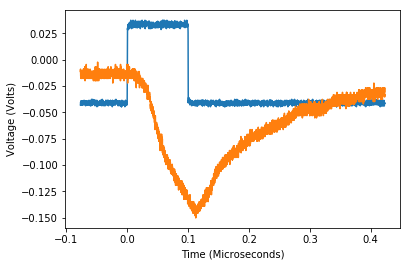

In [3]:
print(outputList.shape,inputList.shape,timeList.shape)

#Plot the first waveforms
fig, ax = plt.subplots()
ax.plot(timeList,inputList[0],label="Input Pulse")
ax.plot(timeList,outputList[0],label="Preamp Output")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")

/home/svergani/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


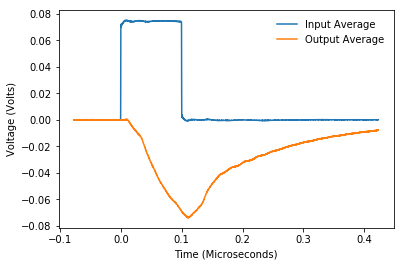

In [4]:
dt=timeList[1]-timeList[0]
fs=1./dt
inputAvg=np.mean(inputList,axis=0)
outputAvg=np.mean(outputList,axis=0)
inputAvg-=np.mean(inputAvg[0:100])
outputAvg-=np.mean(outputAvg[0:100])
#print(inputAvg.shape)

inputSmooth=ppt.butter_lowpass_filter(inputList[0],1000,fs,2)
outputSmooth=ppt.butter_lowpass_filter(outputList[0],1000,fs,2)

fig, ax = plt.subplots()
#ax.plot(timeList,inputSmooth,label="Input Smooth")
#ax.plot(timeList,outputSmooth,label="Output Smooth")
ax.plot(timeList,inputAvg,label="Input Average")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()

In [7]:


timeList[120]



-0.06503911934856271

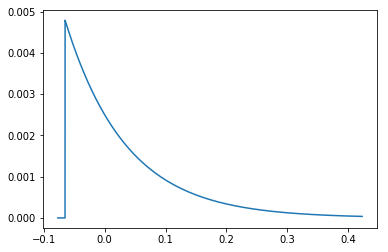

In [8]:


#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response(x,offset,tau,norm):
    conds = [x<0,(x>=0) & (x < offset), x>=offset]   #The two regions of x
    funcs = [lambda x: 0, lambda x:0, lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it


offset=timeList[120]
tau=0.1
norm=0.0025
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response(timeList[0:10000],offset,tau,norm),label="Response Function")



[-0.06503912  0.12486632 -0.00082944]


/home/svergani/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/svergani/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


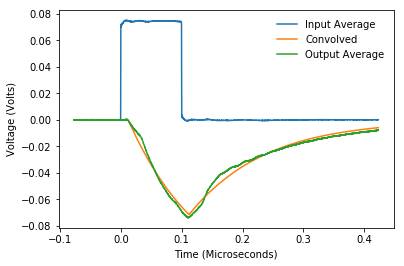

In [9]:
def func(xdata,offset,tau,norm):
    return scipy.signal.convolve(xdata, response(timeList[0:10000],offset,tau,norm), mode='full')[0:len(xdata)] 


from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, inputAvg, outputAvg,p0=[offset,tau,-1*norm])
print(popt)
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
#ax.plot(timeList,inputSmooth,label="2nd Order")
ax.plot(timeList,func(inputAvg,popt[0],popt[1],popt[2]),label="Convolved")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()
#ax.set_xlim(-0.01,0.111)

In [ ]:
#####my version

In [ ]:


#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response(x,offset,tau,norm):
    conds = [x < offset, (x>=offset) & (x<peak),x>=peak]   #The two regions of x
    funcs = [lambda x:0, lambda x: norm*(1-np.exp(-x/tau)), lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it

peak=timeList[np.argmin(outputAvg)]
print(peak)
offset=timeList[120]
#offset = 0
print(offset)
tau=0.1
norm=0.0020
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response(timeList[0:10000],offset,tau,norm),label="Response Function")



In [ ]:


def func(xdata,offset,tau,norm):
    return scipy.signal.convolve(xdata, response(timeList[0:10000],offset,tau,norm), mode='full')[0:len(xdata)] 


from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, inputAvg, outputAvg,p0=[offset,tau,-1*norm])
print(popt)
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
#ax.plot(timeList,inputSmooth,label="2nd Order")
ax.plot(timeList,func(inputAvg,popt[0],popt[1],popt[2]),label="Convolved")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()
#ax.set_xlim(-0.01,0.111)

